# Time Series Models

## Importing Necessary Libraries

In [45]:
!pip install pmdarima
!pip install arch


In [46]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
from datetime import datetime
from datetime import timedelta
import math

from statsmodels.tsa.stattools import adfuller

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from pandas.plotting import autocorrelation_plot as auto_corr
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn import preprocessing

In [47]:
pd.options.display.max_columns=100 # to see columns

In [48]:
df = pd.read_csv('/content/clean_data.csv')

In [49]:
df.drop(columns=['Unnamed: 0'],inplace=True) #dropping default column

In [50]:
df.head() # to see my data

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.096358   
2        0.0        0.0        0.0        0.0        0.0  211.096358   
3        0.0        0.0        0.0        0.0        0.0  211.096358   
4        0.0        0.0        0.0        0.0        0.0  211.096358   

   Unemployment Type    Size  Super_Bowl  Labor_Day  Thanksgiving  Christmas  \
0         8.106    A  151315       False      False         False      False   
1         8.106    A  151315       False      False         False      False   
2         8.106    A  151315       False      False         False      False   
3         8.106    A  151315       False      False         False      False   
4         8.106    A  151315       False      False         False      False   

   week  month  year  
0     5      2  2010  
1     5      2  2010  
2     5      2  2010  
3     5      2  2010  
4     5      2  2010

In [51]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [52]:
df.set_index('Date', inplace=True) #seting date as index

# Plotting Sales

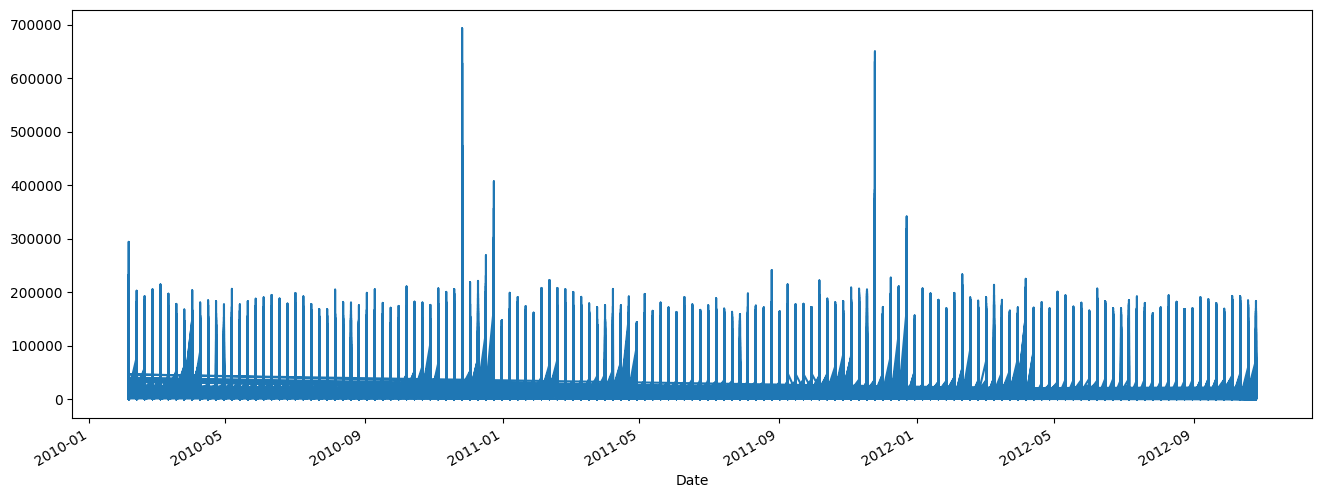

In [53]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [54]:
df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting errors to NaN
df_week = df.resample('W').mean()  # Resample weekly and compute the mean


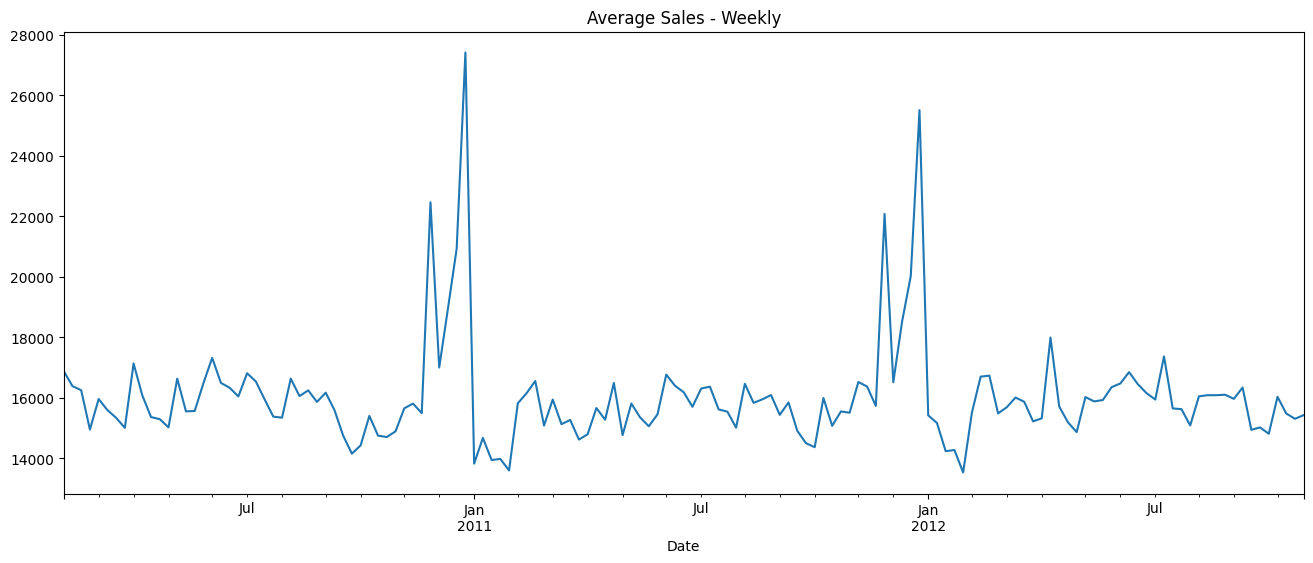

In [55]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [56]:
df_month = df.resample('MS').mean() # resampling as monthly

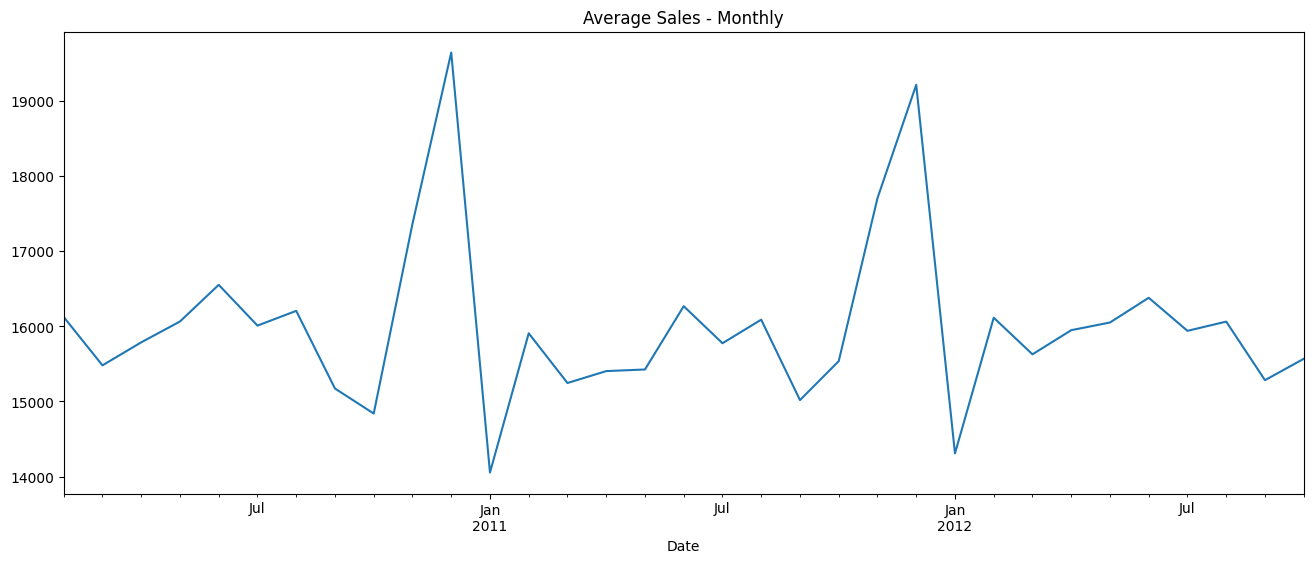

In [57]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

# To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it.

In [58]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

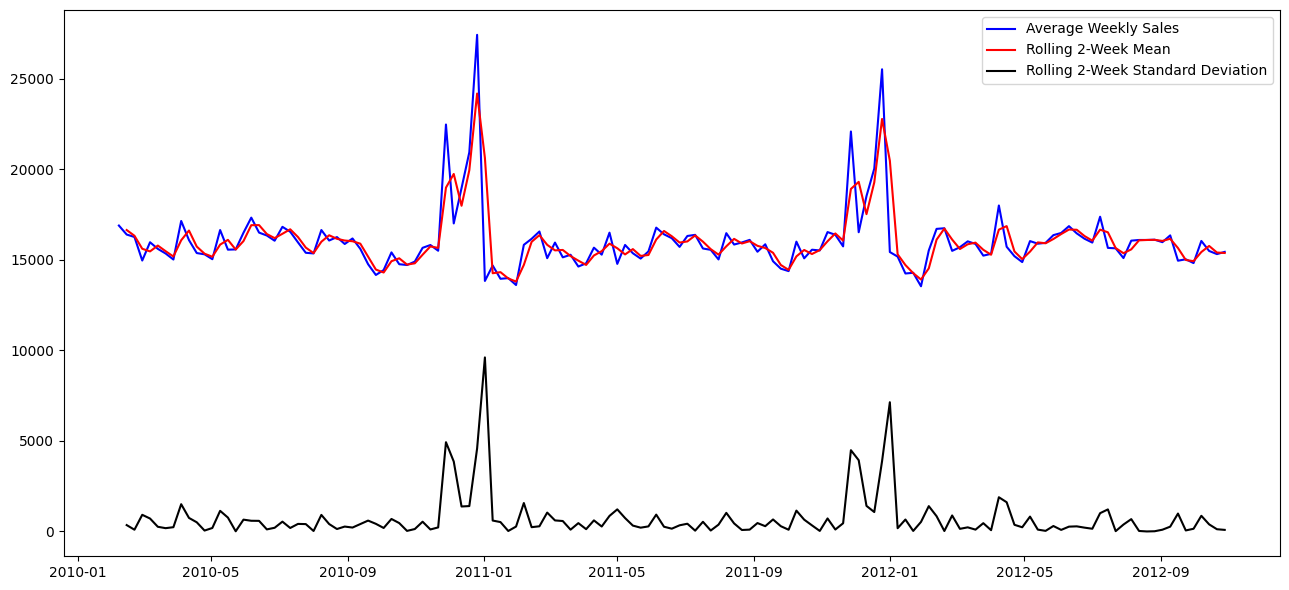

In [59]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

# Adfuller Test to Make Sure

In [60]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

# Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [61]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 22)
Test: (43, 22)


In [62]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

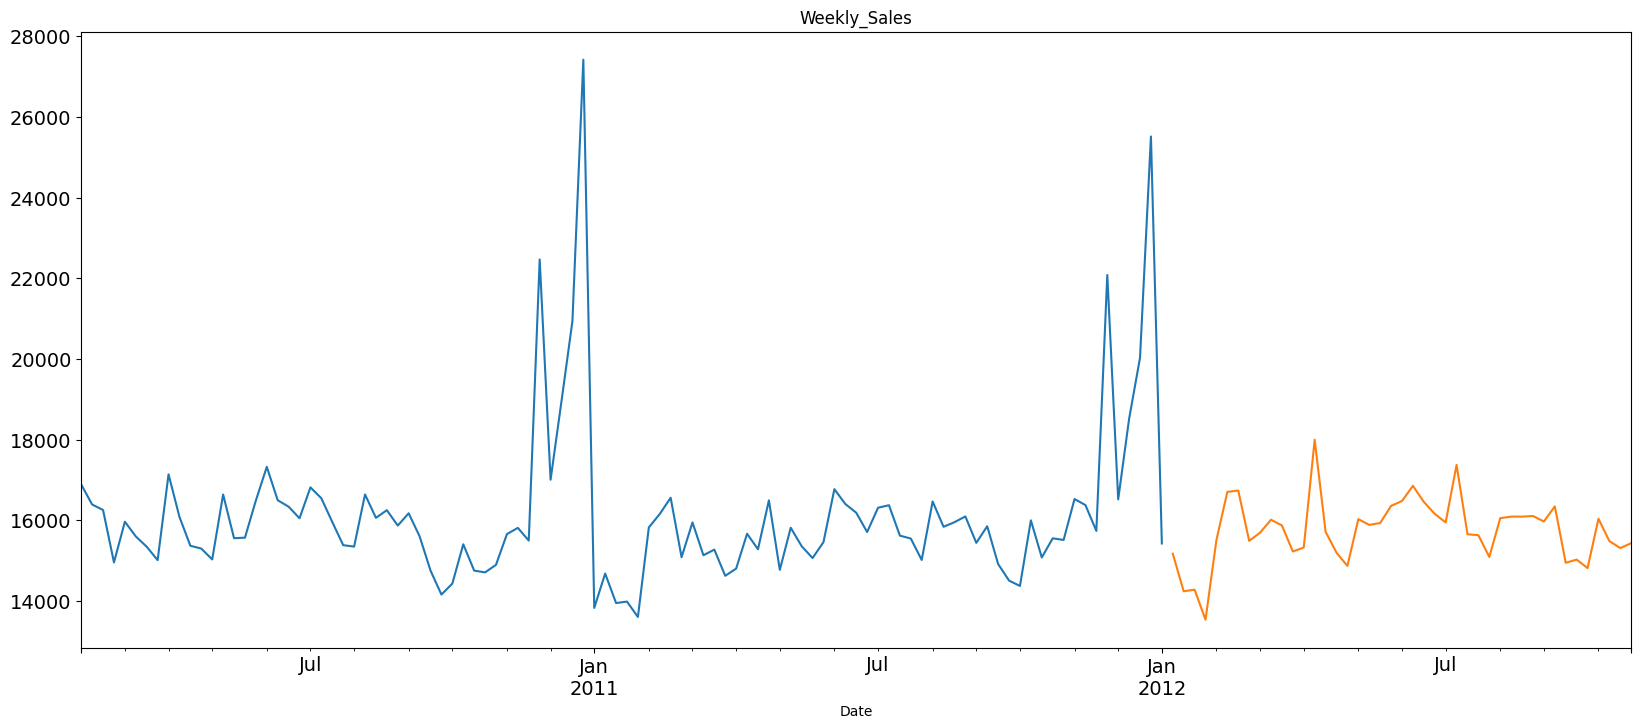

In [63]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

# Decomposing Weekly Data to Observe Seasonality

In [64]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data

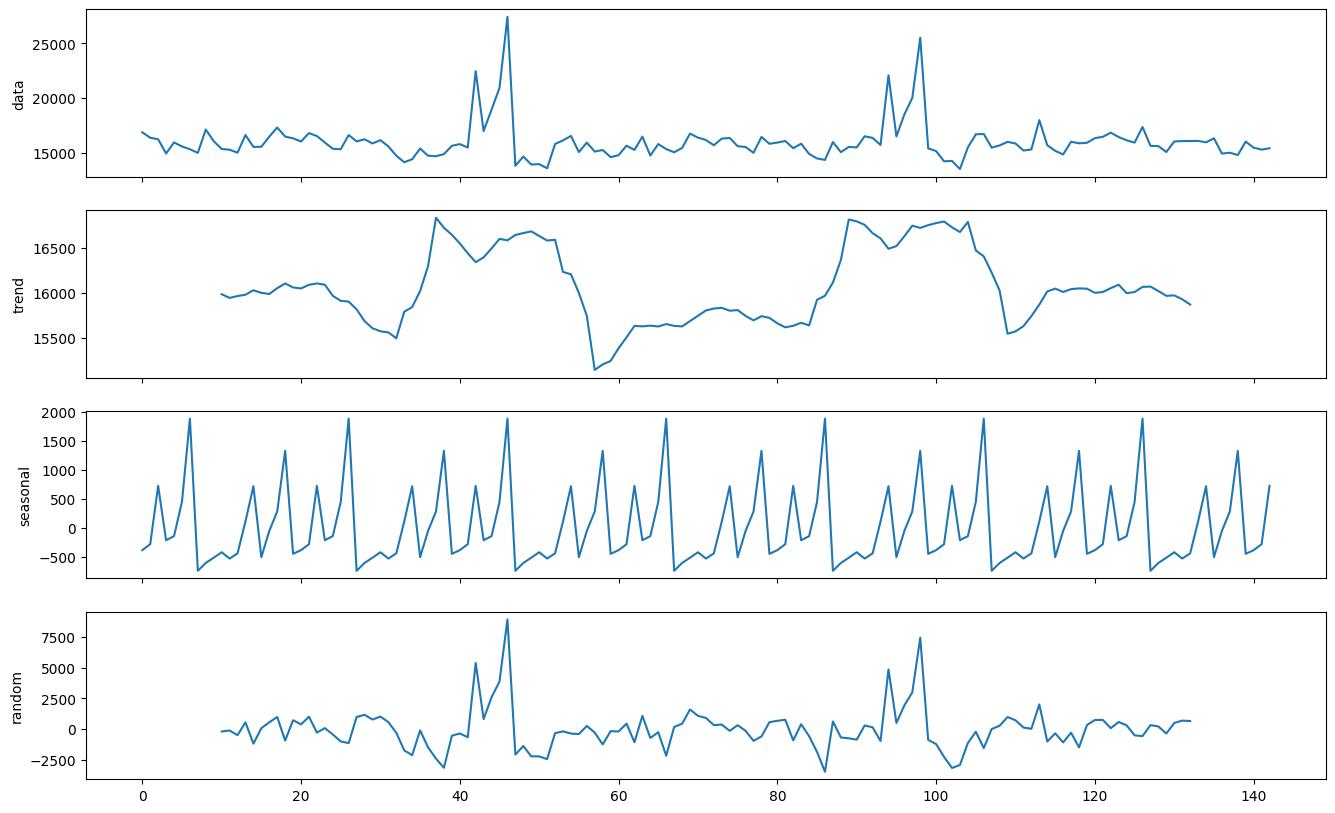

In [65]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

# Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [66]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [67]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

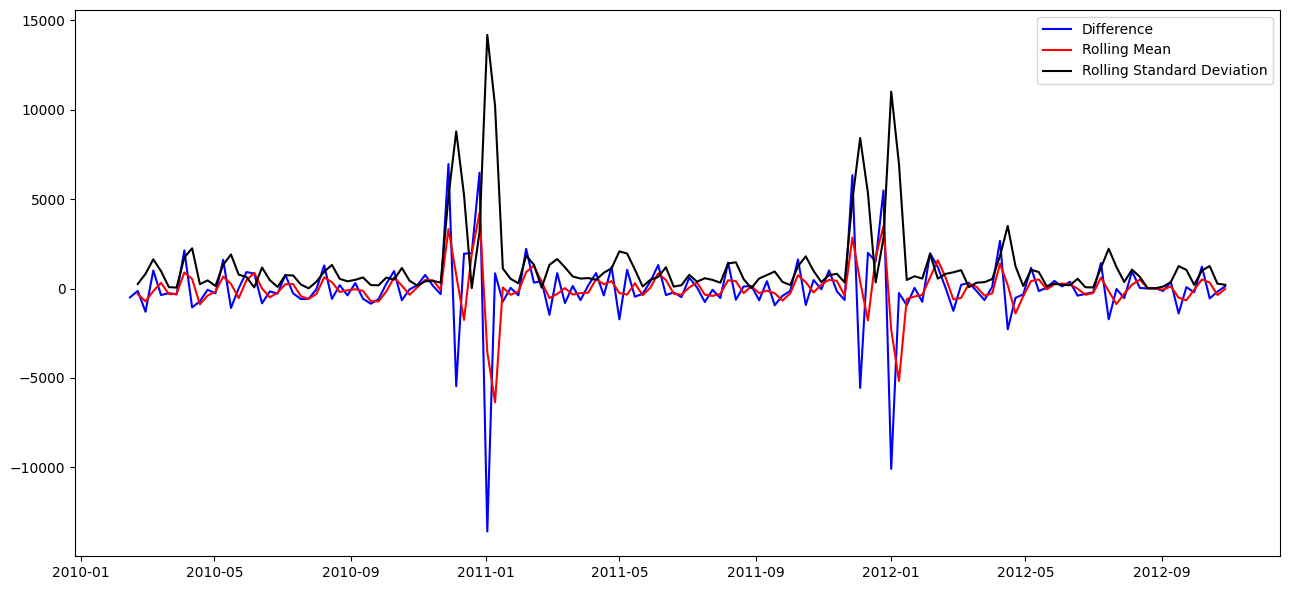

In [68]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [69]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data

In [70]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

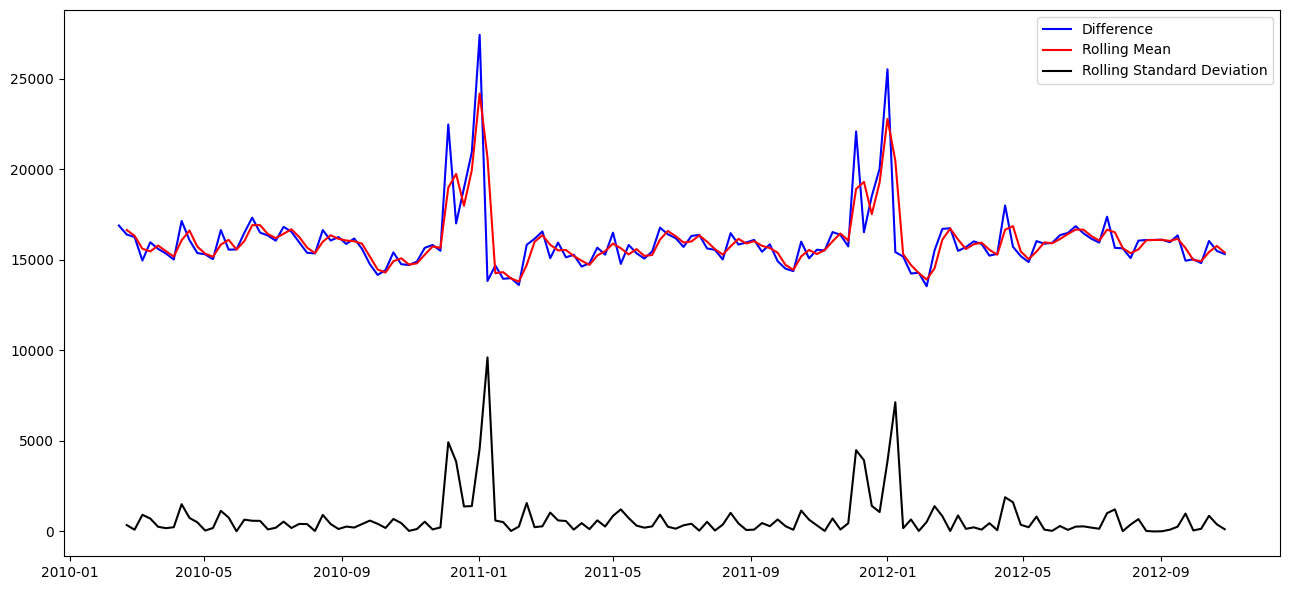

In [71]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [72]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [73]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

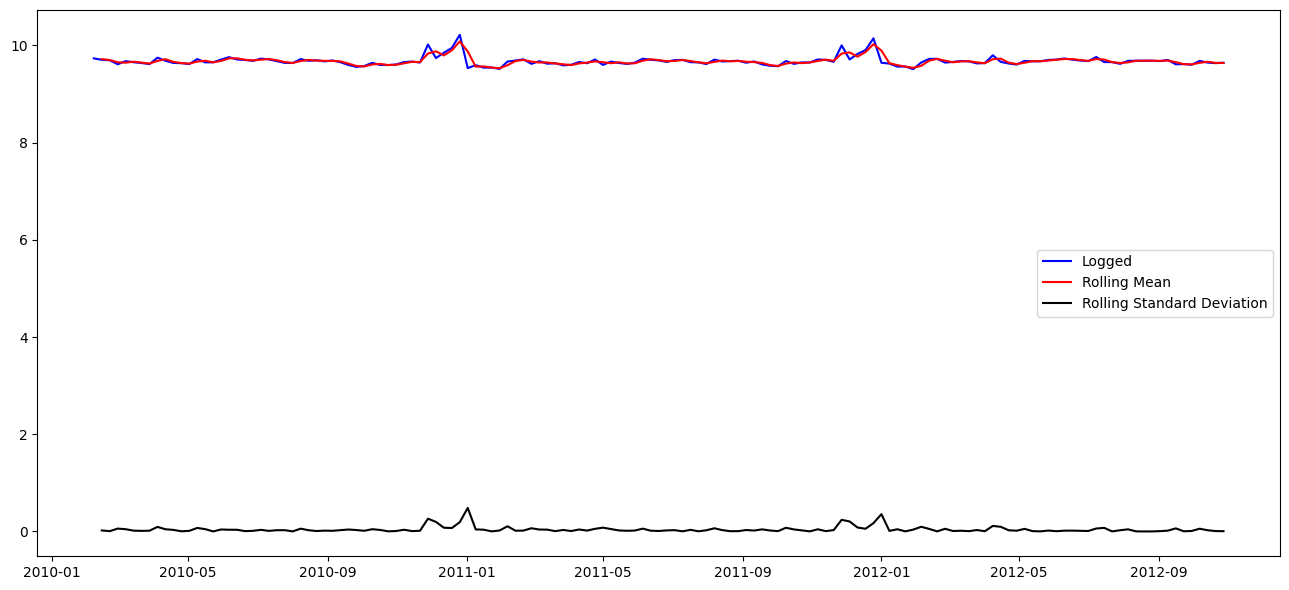

In [74]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data.

### Train-Test Split

In [75]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [76]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

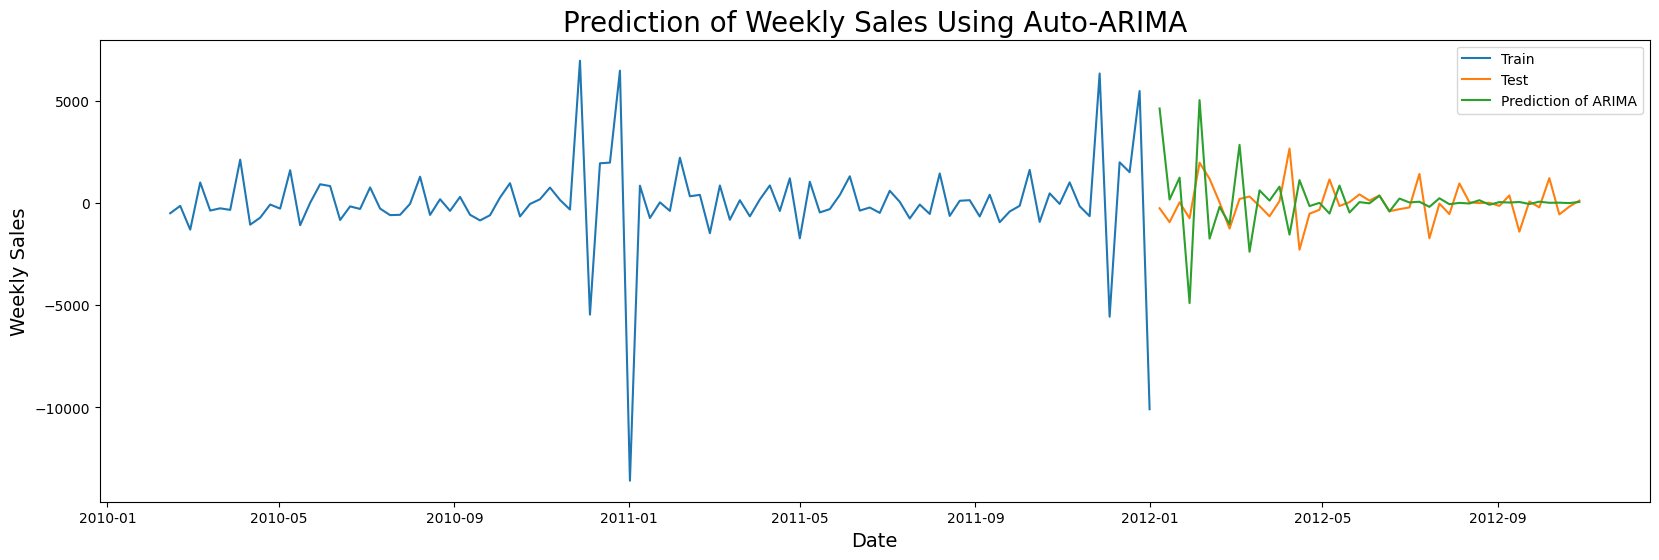

In [77]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred, index=test_data.index, columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

I do not like the pattern of predictions so I decided to try another model.

# ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

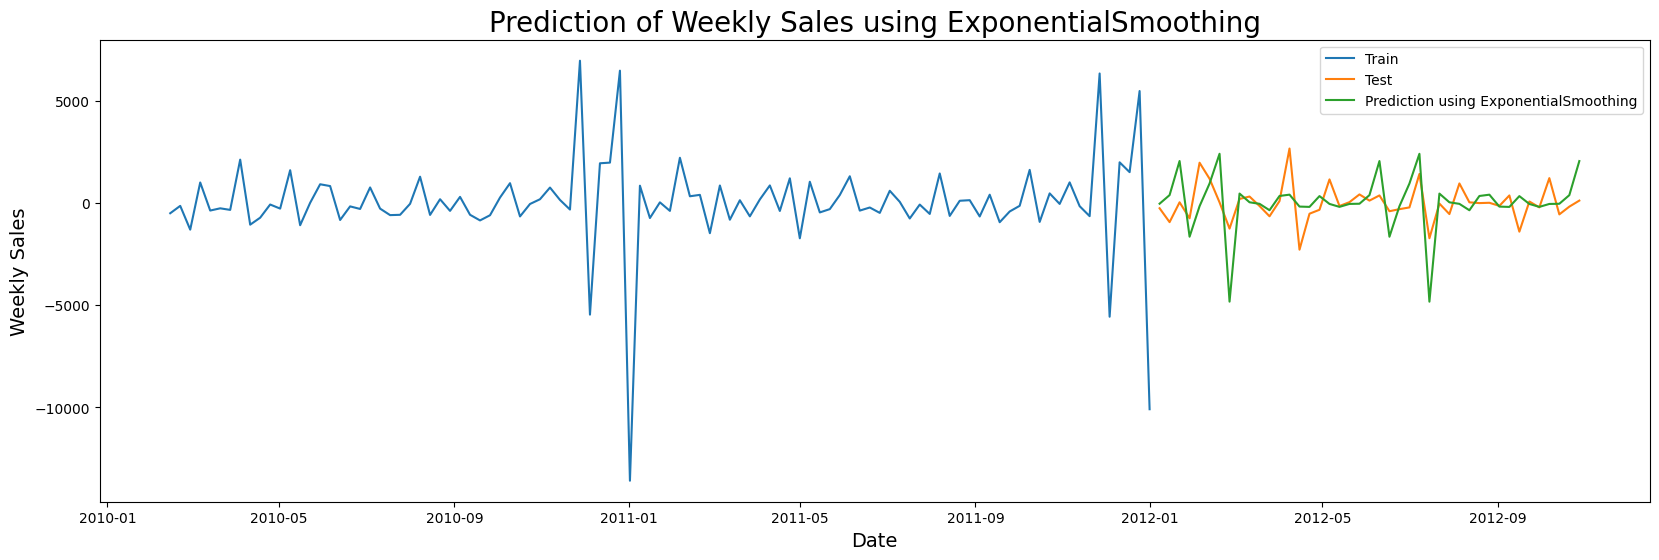

In [78]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


# Metric

Detailed metric explanations can be found in STEP2_RandomForest Notebook.

In [79]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [80]:
wmae_test(test_data_diff, y_pred)

840.681060966696

At the end, I found best results for my data with Exponential Smoothing Model.

# ARCH

I also tried ARCH model with it's different versions like t/ARCH - g/ARCH etc. But, all of them did not give good results, so I did not continue to play with them.

In [81]:
am = arch_model(train_data_diff, vol='GARCH',power=1,o=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 889.1557607946379
Iteration:     10,   Func. Count:     66,   Neg. LLF: 874.1897369270949
Iteration:     15,   Func. Count:     96,   Neg. LLF: 870.8414920454793
Iteration:     20,   Func. Count:    126,   Neg. LLF: 870.689315659005
Iteration:     25,   Func. Count:    156,   Neg. LLF: 870.6890830289894
Iteration:     30,   Func. Count:    186,   Neg. LLF: 868.6826999267321
Iteration:     35,   Func. Count:    216,   Neg. LLF: 868.6500277181112
Iteration:     40,   Func. Count:    246,   Neg. LLF: 868.6407974536786
Optimization terminated successfully    (Exit mode 0)
            Current function value: 868.640796071047
            Iterations: 42
            Function evaluations: 269
            Gradient evaluations: 42
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:           Weekly_Sales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:   

My best result for this project is 821. According to sales amounts this value is roughly around 4-5% error. If we can take our average sales and take percentage of 821 errors, it gives 4-5% roughly.